In [1]:
import pandas as pd
import os
import numpy as np
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import pyro
import pyro.distributions as dist
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer.mcmc import MCMC, HMC, NUTS
from pyro.infer.mcmc.api import MCMC
import pyro.poutine as poutine
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive, JitTrace_ELBO
from pyro.optim import Adam
from pyro.infer.mcmc.util import predictive
from pyro.distributions.util import sum_rightmost

In [3]:
from scipy.stats import uniform, norm
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [5]:
# for CI testing
#assert pyro.__version__.startswith('0.3.4')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

In [6]:
A = 10.2
b = -10.3
c = 1.0
sigma = 0.2
N = 100

In [7]:
np.random.seed(0)
X = torch.from_numpy(uniform.rvs(size=N))
X.detach()
X = X.float()

In [8]:
e = torch.from_numpy(norm.rvs(loc=0, scale=sigma, size=N)).float()
y = A*X.pow(2) + b*X + c + e
y.detach()
y = y.float()

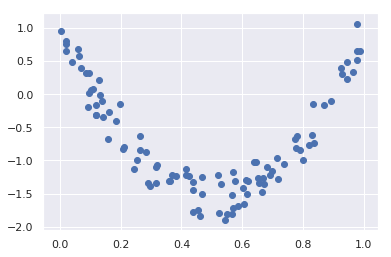

In [9]:
plt.scatter(X.numpy(), y.numpy())

In [10]:
x_data, y_data = X.unsqueeze(1), y

In [11]:
H = 50

In [12]:
class RegressionModel(nn.Module):
    def __init__(self, p):
        super(RegressionModel, self).__init__()
        self.linear1 = nn.Linear(p, H)
        self.linear2 = nn.Linear(H,1)

    def forward(self, x):
        out = F.relu(self.linear1(x))
        out = self.linear2(out)
        return out

p = 1
softplus = nn.Softplus()
regression_model = RegressionModel(p)

In [13]:
for name, param in regression_model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

linear1.weight torch.Size([50, 1])
linear1.bias torch.Size([50])
linear2.weight torch.Size([1, 50])
linear2.bias torch.Size([1])


In [14]:
def model(x_data, y_data):
    options = dict(dtype=x_data.dtype, device=x_data.device)
    
    weight_loc = torch.zeros(H, p, **options)
    weight_scale = 5*torch.ones(H, p, **options)
    bias_loc = torch.zeros(H, **options)
    bias_scale = 5*torch.ones(H, **options)
    
    linear1_w_prior = Normal(weight_loc, weight_scale).independent(2)
    linear1_b_prior = Normal(bias_loc, bias_scale).independent(1)
    
    weight_loc = torch.zeros(1, H, **options)
    weight_scale = 5*torch.ones(1, H, **options)
    bias_loc = torch.zeros(1, **options)
    bias_scale = 5*torch.ones(1, **options)
    
    linear2_w_prior = Normal(weight_loc, weight_scale).independent(2)
    linear2_b_prior = Normal(bias_loc, bias_scale).independent(1)
    
    priors = {'linear1.weight': linear1_w_prior, 'linear1.bias': linear1_b_prior,
              'linear2.weight': linear2_w_prior, 'linear2.bias': linear2_b_prior,}
    
    lifted_module = pyro.random_module("module", regression_model, priors)
    
    lifted_reg_model = lifted_module()
    
    with pyro.plate("map"):
        prediction_mean = lifted_reg_model(x_data).squeeze(-1)
        pyro.sample("obs", Normal(prediction_mean, 0.2), obs=y_data)
    return prediction_mean

In [15]:
from pyro.contrib.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model)

In [16]:
pyro.clear_param_store()

In [17]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=1000)

In [18]:
num_iterations = 10000
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(y_data)))

[iteration 0001] loss: 5229.2861
[iteration 0101] loss: 2970.9610
[iteration 0201] loss: 121.1777
[iteration 0301] loss: 4342.7235
[iteration 0401] loss: 3091.1835
[iteration 0501] loss: 328.4816
[iteration 0601] loss: 1465.7486
[iteration 0701] loss: 76.7010
[iteration 0801] loss: 297.7923
[iteration 0901] loss: 37.2671
[iteration 1001] loss: 97.9540
[iteration 1101] loss: 36.2006
[iteration 1201] loss: 200.9383
[iteration 1301] loss: 32.0047
[iteration 1401] loss: 22.0476
[iteration 1501] loss: 409.9832
[iteration 1601] loss: 364.3596
[iteration 1701] loss: 268.1059
[iteration 1801] loss: 101.9152
[iteration 1901] loss: 16.9799
[iteration 2001] loss: 59.7375
[iteration 2101] loss: 9.5369
[iteration 2201] loss: 51.9448
[iteration 2301] loss: 12.5927
[iteration 2401] loss: 28.6326
[iteration 2501] loss: 43.9128
[iteration 2601] loss: 174.9121
[iteration 2701] loss: 14.1341
[iteration 2801] loss: 19.3252
[iteration 2901] loss: 52.3441
[iteration 3001] loss: 27.3048
[iteration 3101] loss

In [19]:
get_marginal = lambda traces, sites:EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()

def wrapped_model(x_data, y_data):
    pyro.sample("prediction", Delta(model(x_data, y_data)))

posterior = svi.run(x_data, y_data)

In [20]:
x_test = torch.linspace(0.0, 1.0).unsqueeze(1)

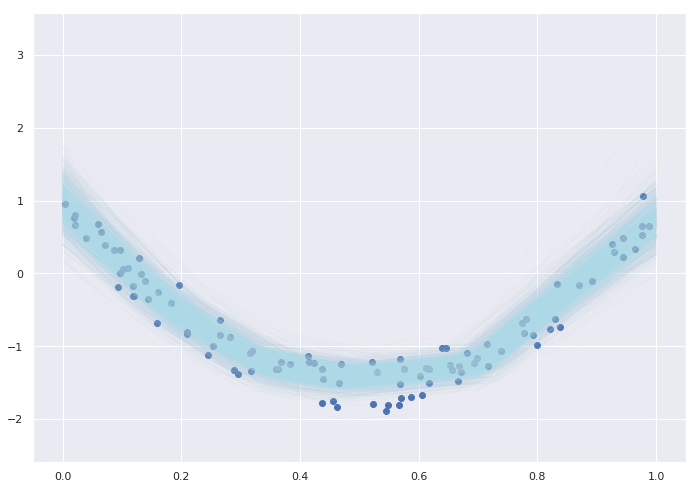

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.scatter(X,y)
for _ in range(1000):
    guide_trace = poutine.trace(guide).get_trace(x_test, None)
    lifted_reg_model = poutine.replay(model, guide_trace)
    y_test = lifted_reg_model(x_test, None)
    plt.plot(x_test.detach().cpu().numpy(), y_test.detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [21]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

auto_loc tensor([-0.1230, -2.2260, -2.4973, -0.0123, -3.5632, -0.6358, -0.4926, -0.7853,
        -4.2915,  2.8750, -2.8906, -1.5027, -0.7422, -2.6805, -1.4446, -3.3045,
        -2.6496, -1.9266,  1.4222, -1.9845,  0.8113, -0.1373,  0.1595,  1.5636,
         0.4178, -0.2736,  0.5059,  0.2236,  1.5914,  2.3502, -1.4142],
       requires_grad=True)
auto_scale tensor([1.0098, 0.8436, 0.9415, 0.6131, 1.4568, 0.7515, 0.6159, 0.8215, 0.1394,
        0.0223, 0.6928, 0.4565, 0.4036, 0.4830, 0.4957, 0.6910, 0.4495, 0.5640,
        0.0258, 0.0218, 3.3881, 0.7367, 0.5325, 1.1649, 1.3053, 3.4871, 1.4642,
        1.3569, 0.0467, 0.0800, 0.0225], grad_fn=<AddBackward0>)
